 ***INTRODUCTION and DATASET OVERVIEW*** : The Stanford Question Answering Dataset (SQuAD) v2, available on Hugging Face Datasets, is a benchmark for evaluating machine reading comprehension and question-answering models. It includes both answerable and unanswerable questions, challenging models to extract accurate answers or identify when no valid answer exists. The main goal of this project is to develop a robust question-answering model that can accurately extract answers from a given context while also identifying when a question is unanswerable. By leveraging the SQuAD v2 dataset, the project aims to fine-tune a transformer-based model, such as BERT or RoBERTa, to enhance its ability to understand context, reason effectively, and handle real-world QA scenarios where answers may or may not exist. This project ultimately seeks to build a reliable and intelligent QA system applicable to practical use cases.

# Installing and Importing Required **Libraries**

In [1]:
pip install datasets transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jupyterthemes


Note: you may need to restart the kernel to use updated packages.


In [3]:
!jt -t monokai -f fira -fs 12 -tfs 12 -cellw 90% -lineh 150 -altp -altmd -ynb


usage: jt [-h] [-l] [-t THEME] [-f MONOFONT] [-fs MONOSIZE] [-nf NBFONT]
          [-nfs NBFONTSIZE] [-tf TCFONT] [-tfs TCFONTSIZE] [-dfs DFFONTSIZE]
          [-ofs OUTFONTSIZE] [-mathfs MATHFONTSIZE] [-m MARGINS]
          [-cursw CURSORWIDTH] [-cursc CURSORCOLOR] [-cellw CELLWIDTH]
          [-lineh LINEHEIGHT] [-altp] [-altmd] [-altout] [-P] [-T] [-N] [-kl]
          [-vim] [-r] [-dfonts]
jt: error: unrecognized arguments: -ynb


In [4]:
import re
import torch
from datasets import load_dataset, load_from_disk, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### DATA LOADING: Loaded the "rajpurkar/squad_v2" dataset

In [5]:
raw_dataset = load_dataset("rajpurkar/squad_v2")
print(raw_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


In [6]:
train_dataset = raw_dataset["train"]
validation_dataset = raw_dataset["validation"]
print(f"Train Dataset is {train_dataset}\n")
print(f"Validation Dataset is {validation_dataset}\n")

Train Dataset is Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

Validation Dataset is Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})



# DATA CLEANING


In [7]:
#Removed unnecessary whitespace to ensure uniform formatting using strip function
def clean_text(text):
  text = re.sub('\s+', ' ', text)
  text = text.strip()
  return text

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_f/py9grhcj2c5f9506sl78n_1w0000gn/T/ipykernel_6563/2965519770.py:3: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [8]:
#Normalized the cleaned text and made it consistent for both the context and the question
def apply_clean_text(examples):
  cleaned_contexts = [clean_text(c) for c in examples['context']]
  cleaned_questions = [clean_text(q) for q in examples['question']]
  return {
      "context": cleaned_contexts,
      "question": cleaned_questions
  }


In [9]:
#Mapping the clean dataset to train, test and validation dataset
train_dataset = train_dataset.map(
    apply_clean_text,
    batched = True, #process the dataset in batches
    num_proc = 4 #spiltted the map operation accross CPU 4 cores to speed up the mapping operation
)
validation_dataset = validation_dataset.map(
    apply_clean_text,
    batched = True,
    num_proc = 4

)

In [10]:
#loaded the tokenizer compatible with Bert(Bidirectional Encoded Representations from Transformers)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [11]:
#Pre-processing a batch of training examples for question answeing model
def preprocess_training_examples(examples):
  # Argument = examples (dict): A batch of examples containing:
  # 1: "question": A list of questions (strings).
  # 2: "context": A list of contexts (strings).
  # 3: "answers": A list of dictionaries with the keys:
  # 4: "text": The actual answer text(s)

  #Tokenzied the question and context
  tokenized = tokenizer(
      examples["question"], #tokenized the questions
      examples["context"],  #tokenized the context
      truncation = True,   #cut of input sequence(question+context) if it exceeds the max_length
      stride = 128,  #overlap between chunks when splitting long context
      return_overflowing_tokens = True, #return token split into multiple chunks
      return_offsets_mapping = True, #return character to token position mapping
      padding = "max_length" #all sequences are padded to the model's max_length
  )
  offset_mapping = tokenized["offset_mapping"]
  sample_map = tokenized.pop("overflow_to_sample_mapping")
  #stored the start and end token position of the answers in a list
  start_positions = []
  end_positions = []
  #Iterate over each chunk in tokenized batch size
  for i, offsets in enumerate(offset_mapping):
    sample_idx = sample_map[i] #index of the chunk
    answers = examples["answers"][sample_idx] #retrieving answes
    #if no answers are provided the start and end position is set to be zero
    if len(answers["text"]) == 0:
      start_positions.append(0)
      end_positions.append(0)
      continue
    #Extracting first answer text and character start position
    answer_text = answers["text"][0]
    answer_start_char = answers["answer_start"][0]
    answer_end_char = answer_start_char + len(answer_text)
    #Initializing the value of start and end token index
    start_token_idx = 0
    end_token_idx = 0
    #Iterate through token indices to find start and end token indices
    for idx, (start,end) in enumerate(offsets):
      if start <= answer_start_char < end: #to check if the start of the answer fell within the token
        start_token_idx = idx
      if start < answer_end_char <= end: #to check if the end of the answer fell within the token
        end_token_idx = idx
        break #exit the loop if it has been found
    #append identified token indices to the given list
    start_positions.append(start_token_idx)
    end_positions.append(end_token_idx)
  #add start and end positions to the tokenized dictionary
  tokenized["start_positions"] = start_positions
  tokenized["end_positions"] = end_positions
  return tokenized #return tokenized input within the given position of the answer

In [12]:
#Tokenized and Preprocessed the training dataset and removed the original column to avoid redundancy
tokenized_train = train_dataset.map(
    preprocess_training_examples,
    batched = True,
    remove_columns = train_dataset.column_names
)
#Tokenized and Preprocessed the validation dataset and removed the original column to avoid redundancy

tokenized_validation = validation_dataset.map(
    preprocess_training_examples,
    batched = True,
    remove_columns = validation_dataset.column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

### Convert Dataset into Tensor Format

In [13]:
#Converted the tokenized dataset into Pytorch Sensors after formatting each set to pytorch tensors
tokenized_train.set_format("torch", columns = ["input_ids", "attention_mask", "start_positions", "end_positions"])
tokenized_validation.set_format("torch", columns = ["input_ids", "attention_mask", "start_positions", "end_positions"])

In [14]:
#Created a dataloader for tokenized datasets with shuffling at epoch to improve model performance and be as much unbias as possible
train_dataloader = DataLoader(tokenized_train, shuffle = True, batch_size = 8)
validation_dataloader = DataLoader(tokenized_validation, shuffle = True, batch_size = 8)

In [15]:
#fetched the first batch from train dataloader and iterated over the batch items(keys and values)
sample_batch = next(iter(train_dataloader))
for k,v in sample_batch.items():
  print(k,v.shape)

input_ids torch.Size([8, 512])
attention_mask torch.Size([8, 512])
start_positions torch.Size([8])
end_positions torch.Size([8])


### Save Processed Data

In [16]:
#Created a DatasetDict to organize the  preprocess datasets
processed_dataset = DatasetDict(
    {
        "train" : tokenized_train, #Assigned the tokenized training dataset to the "train" split
        "validation" : tokenized_validation,  #Assigned the tokenized validation dataset to the "validation" split
    }
)
# Saved the processed dataset to disk for using it
processed_dataset.save_to_disk("processed_squad_v2")


Saving the dataset (0/4 shards):   0%|          | 0/130544 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11974 [00:00<?, ? examples/s]

In [17]:
reload_processed_dataset = load_from_disk("processed_squad_v2")#reload the preprocessed dataset

# Create a Shallow Neural Network

In [18]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [19]:
class ShallowNeuralNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ShallowNeuralNetwork, self).__init__()
    # Hidden later
    # hidden_dim represents the number of neurons in the hidden layer
    self.hidden_layer = nn.Linear(input_dim, hidden_dim)
    # Output layer
    self.output_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # Pass batch into hidden layer
    x = self.hidden_layer(x)
    # Apply relu function on hidden layer outputs
    x = torch.relu(x)
    # Final linear layer to produce logits
    x = self.output_layer(x)
    return x

## Train the Network

In [20]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
  # put model in training mode
  model.train()
  running_loss = 0.0
  for batch in dataloader:
    # batch is a dictionary with keys: input_ids, attention_mask, start_positions, end_positions
    # Move data to device
    input_ids = batch["input_ids"].to(device)
    start_positions = batch["start_positions"].to(device)
    end_positions = batch["end_positions"].to(device)

    # Convert input_ids to float to feed into linear layers
    input_ids = input_ids.float()

    # Zero out any previously accumulated gradients
    optimizer.zero_grad()

    # Forward pass
    logits = model(input_ids)
    batch_size, out_dim = logits.shape

    # First half of logits as the distribution over start positions (512)
    # Second half as the distribution over end positions (512).
    half_dim = out_dim // 2
    start_logits = logits[:, :half_dim]  # shape [batch_size, 512]
    end_logits = logits[:, half_dim:]    # shape [batch_size, 512]

    # Compute loss
    # Apply CrossEntropyLoss for start_logits vs. start_positions and for end_logits vs. end_positions. Take sum of the loss.
    loss_start = criterion(start_logits, start_positions)
    loss_end = criterion(end_logits, end_positions)
    loss = loss_start + loss_end

    # Backpropagate
    loss.backward()

    # Update parameters
    optimizer.step()

    # Accumulate the loss
    running_loss += loss.item()

  average_loss = running_loss / len(dataloader)
  return average_loss


## Test the Network

In [21]:
def evaluate(model, dataloader, criterion, device):
  # set model to evaluation mode
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
    for batch in dataloader:
      # Move data to device
      input_ids = batch["input_ids"].to(device)
      start_positions = batch["start_positions"].to(device)
      end_positions = batch["end_positions"].to(device)

      input_ids = input_ids.float()

      # Forward
      logits = model(input_ids)
      batch_size, out_dim = logits.shape
      half_dim = out_dim // 2
      start_logits = logits[:, :half_dim]
      end_logits = logits[:, half_dim:]

      # Compute the loss
      loss_start = criterion(start_logits, start_positions)
      loss_end = criterion(end_logits, end_positions)
      loss = loss_start + loss_end

      running_loss += loss.item()

  average_loss = running_loss / len(dataloader)
  return average_loss


## Hyperparameter Experiment

In [22]:
def hyperparameter_experiment(hidden_dims_list, train_dataloader, test_dataloader, input_dim, num_epochs, learning_rate):
  # Train a new model for each hidden_dim, evaluate on test set, and record the test loss.
  test_losses = []
  for hidden_dim in hidden_dims_list:
    print(f"\nTraining a network with hidden_dim = {hidden_dim}")

    # Instantiate model
    # Output dimension is 2*input_dim for predicting start and end positions
    model = ShallowNeuralNetwork(input_dim, hidden_dim, output_dim=2*input_dim)
    # move to GPU if available
    model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function (CrossEntropyLoss)
    criterion = nn.CrossEntropyLoss()

    # Train model
    for epoch in range(num_epochs):
      train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
      print(f"  Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # Evaluate on test set
    test_loss = evaluate(model, test_dataloader, criterion, device)
    test_losses.append(test_loss)
    print(f"  Test Loss after training: {test_loss:.4f}")

  return test_losses


## Execute the experiment and plot results

In [23]:
hidden_dims = [2, 4, 8, 16, 32, 64]

# Run the experiment
test_losses = hyperparameter_experiment(
    hidden_dims,
    train_dataloader,
    validation_dataloader,
    input_dim=512,
    num_epochs=10,
    learning_rate=0.001
)


Training a network with hidden_dim = 2
  Epoch 1/10, Train Loss: 9.0748
  Epoch 2/10, Train Loss: 8.2995
  Epoch 3/10, Train Loss: 8.3003
  Epoch 4/10, Train Loss: 8.3017
  Epoch 5/10, Train Loss: 8.3036
  Epoch 6/10, Train Loss: 8.3049
  Epoch 7/10, Train Loss: 8.3053
  Epoch 8/10, Train Loss: 8.3063
  Epoch 9/10, Train Loss: 8.3068
  Epoch 10/10, Train Loss: 8.3075
  Test Loss after training: 6.8294

Training a network with hidden_dim = 4
  Epoch 1/10, Train Loss: 9.2737
  Epoch 2/10, Train Loss: 8.2994
  Epoch 3/10, Train Loss: 8.2998
  Epoch 4/10, Train Loss: 8.3022
  Epoch 5/10, Train Loss: 8.3037
  Epoch 6/10, Train Loss: 8.3045
  Epoch 7/10, Train Loss: 8.3057
  Epoch 8/10, Train Loss: 8.3067
  Epoch 9/10, Train Loss: 8.3073
  Epoch 10/10, Train Loss: 8.3074
  Test Loss after training: 6.8280

Training a network with hidden_dim = 8
  Epoch 1/10, Train Loss: 9.7808
  Epoch 2/10, Train Loss: 8.2990
  Epoch 3/10, Train Loss: 8.3000
  Epoch 4/10, Train Loss: 8.3017
  Epoch 5/10, Tr

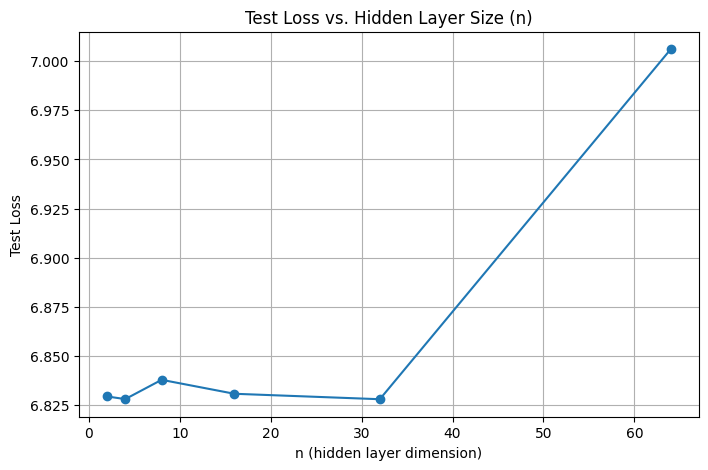

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(hidden_dims, test_losses, marker='o')
plt.title("Test Loss vs. Hidden Layer Size (n)")
plt.xlabel("n (hidden layer dimension)")
plt.ylabel("Test Loss")
plt.grid(True)
plt.show()

Analysis of Shallow Results  
• As n increases from 2 to 4 to 32, the test loss remains around 6.82–6.83.  
• Eventually, at n=64, the test loss rises (7.0061), suggesting that increasing n beyond a certain point does not help and may even hurt (likely due to overfitting or poor initialization).  
• From these runs, the optimal n appears to be around 4, 8, 16, or 32 (they all yield test losses in the same 6.82−6.83 range). For simplicity, we might say n=4 or n=32 had the lowest reported test loss of ~6.828.  
